# extract arome wind data and store

In [4]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd
import xarray as xr

# cognac data and tools
#import cognac.insitu as iu
#import pynsitu as pin

----

## wind, arome

To be done on datarmor.
Copy extracted netcdf file back on laptop.


In [5]:
import xarray as xr
import pandas as pd
from glob import glob

In [6]:
arome_dir = "/home/ref-oc-intranet-restricted/modeles_mf/arome_v2/best_estimate/"

def load_arome(t, dt=None, freq="1H", rkwargs={}, **kwargs):
    """ Extract ERA data
    https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5
    
    Parameters
    ----------
    t: date-like object, list
        date for extraction, [tstart, tend]
    dt: tuple, optional
        time interval in days around t
    freq: str
        frequency of outputs selected, e.g. "1H" or "1D"
    rkwargs: dict
        passed to load_dataset
    **kwargs: passed for direct selection
    """
    
    if not isinstance(t, list):
        t = [t, t]
    t = [pd.to_datetime(_t) for _t in t]
    
    if dt is not None:
        t = [_t+pd.Timedelta(days=_dt) for _t, _dt in zip(t, range(*dt))]
        t = pd.date_range(t[0], t[-1], freq=freq)
    else:
        t = [t]
    
    #
    D = []
    for _t in t:
        _rpath = f"{_t.year}/METEOFRANCE_AROME_{_t.year}{_t.month:02d}{_t.day:02d}T{_t.hour:02d}Z*.nc"
        files = glob(os.path.join(arome_dir, _rpath)) 
        _ds = xr.merge([xr.load_dataset(f, **rkwargs).squeeze().sel(**kwargs) for f in files])
        D.append(_ds)
    ds = xr.concat(D, dim="time")

    return ds

In [17]:
dt = (-30, 5)

# 
deployment = "2019_summer_toulon"
t_start = pd.Timestamp(2019,7,13)
t_end = pd.Timestamp(2019,7,31)

# 
deployment = "2020_spring_toulon"
t_start = pd.Timestamp(2020,4,13)
t_end = pd.Timestamp(2020,5,12)

# 
deployment = "2020_autumn_toulon"
t_start = pd.Timestamp(2020,10,16)
t_end = pd.Timestamp(2020,11,5)

# 
deployment = "2021_winter_toulon"
t_start = pd.Timestamp(2020,12,11)
t_end = pd.Timestamp(2021,1,6)

# 
deployment = "2021_spring_monaco"
t_start = pd.Timestamp(2021,4,30)
t_end = pd.Timestamp(2021,6,9)

# 
deployment = "2022_summer_toulon"
t_start = pd.Timestamp(2022,6,3)
t_end = pd.Timestamp(2022,6,13)

cable=deployment.split("_")[-1]
if cable=="toulon":
    lon = slice(5, 7)
    lat = slice(42, 43.5)
elif cable=="monaco":
    lon = slice(7., 8.5)
    lat = slice(43.3, 44.2)

ds = load_arome([t_start, t_end], dt=dt, longitude=lon, latitude=lat).chunk(dict(time="auto"))

nc = os.path.join(os.getenv("SCRATCH"), deployment+"_arome.nc")
ds.to_netcdf(nc, mode="w")

print(f"{nc} written")

/home1/scratch/aponte/2022_summer_toulon_arome.nc written


### quick overview

In [9]:
ds = xr.open_dataset("/home1/scratch/aponte/2019_summer_toulon_arome.nc")
ds

<xarray.Dataset>
Dimensions:    (time: 457, latitude: 61, longitude: 81)
Coordinates:
  * time       (time) datetime64[ns] 2019-06-13 ... 2019-07-02
  * latitude   (latitude) float32 42.0 42.03 42.05 42.08 ... 43.45 43.47 43.5
  * longitude  (longitude) float32 5.0 5.025 5.05 5.075 ... 6.925 6.95 6.975 7.0
    height     float32 ...
Data variables: (12/13)
    hu2m       (time, latitude, longitude) float32 ...
    nebul      (time, latitude, longitude) float32 ...
    pmer       (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    u10m       (time, latitude, longitude) float32 ...
    v10m       (time, latitude, longitude) float32 ...
    ...         ...
    flsen      (time, latitude, longitude) float32 ...
    flsolaire  (time, latitude, longitude) float32 ...
    fltherm    (time, latitude, longitude) float32 ...
    ustress    (time, latitude, longitude) float32 ...
    vstress    (time, latitude, longitude) float32 ...
    eau        (time, latitude, longitude) float32 ...
Attributes: (12/40)
    data_type:               OCO straight grid
    format_version:          1.2
    title:                   Meteo-France Arome analysis and forecast
    Conventions:             CF-1.3
    netcdf_version:          3.5
    product_name:            METEOFRANCE_AROME_20190613T00Z.nc
    ...                      ...
    data_centre:             CD-OCO
    data_centre_references:  http://www.previmer.org/
    contact:                 cdoco-exploit@ifremer.fr
    distribution_statement:  Data restrictions: for registered users only
    operational_status:      operational
    quality_index:           1

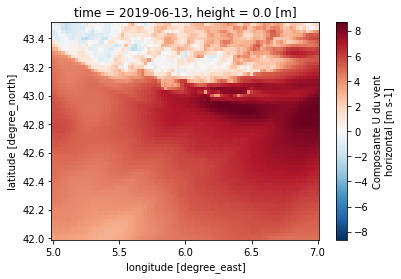

In [10]:
ds.isel(time=0).u10m.plot()

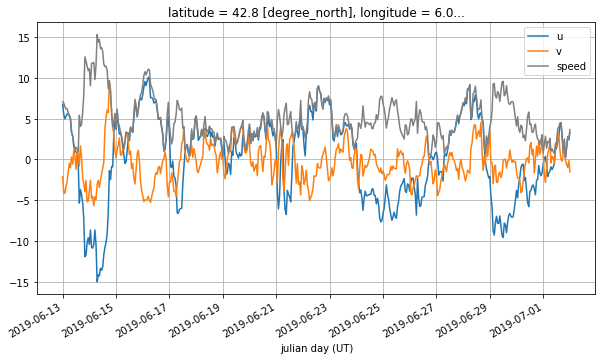

In [12]:
_ds = ds.sel(longitude=6, latitude=42.8, method="nearest")

fig, ax = plt.subplots(1,1, figsize=(10,5))
_ds.u10m.plot(label="u")
_ds.v10m.plot(label="v")
np.sqrt(_ds.u10m**2+_ds.v10m**2).plot(label="speed", color="0.5")

ax.grid()
ax.set_ylabel("")
ax.legend()

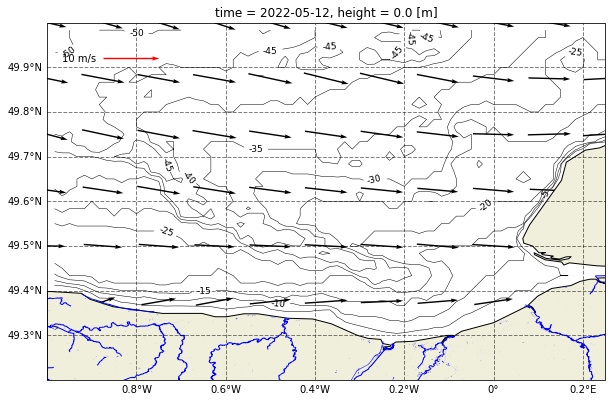

In [42]:
bounds=[-.5, -.1, 49.25, 49.5]
bounds=[-1., .25, 49.2, 50.]
fig, ax, crs = cp.plot_map(bounds=bounds, coast="bseine", land=None, rivers="bseine")

di=5
_ds = (ds.sel(time="2022-05-12 00:00:00")
       .isel(longitude=slice(0,None,di),latitude=slice(0,None,di))
      )

q = _ds.plot.quiver(x="longitude", y="latitude", u="u10m", v="v10m", scale=1e2, transform=crs, zorder=-2)
qk = ax.quiverkey(q, 0.1, 0.9, 10, '10 m/s', transform=crs, color="r",
                  labelpos='W', coordinates='axes', zorder=10)